# INCITE GHG Data
An example script of how to process GHG data from LGR-ICOSTM Microportable Gas Analyzer.

In [1]:
import glob
import zipfile
import pandas as pd
import dask.dataframe as dd
import seaborn as sns

## Unzip files
```file[:24]``` is defined according to the path

In [2]:
path = 'Data/ABB-de7/*/'
filenames = [filename for filename in glob.iglob(path + '*.zip')]
for file in filenames:
    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall(file[:24])

## Read files

### Pandas
https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

In [3]:
%%time

path = 'Data/ABB-de7/*/'

filenames = [filename for filename in glob.iglob(path + '*_f*.txt')]

usecols = ['SysTime', 'Time', '[CH4]_ppm', '[CO2]_ppm', '[H2O]_ppm', '[CH4]d_ppm',
           '[CO2]d_ppm', 'GasP_torr', 'AmbT_C']

list_of_dfs = []
for filename in filenames:
    list_of_dfs.append(pd.read_csv(filename,
                                   sep=',',
                                   skipinitialspace=True,
                                   skiprows=1,
                                   usecols=usecols,
                                   ))
    
df = pd.concat(list_of_dfs, ignore_index=True)

idx_0 = df.loc[df['SysTime'] == '-----BEGIN PGP MESSAGE-----'].index
idx_1 = df.loc[df['SysTime'] == '-----END PGP MESSAGE-----'].index
for i in range(len(idx_0)):
    df = df.drop(df.index[idx_0[-(i+1)]:idx_1[-(i+1)]+1])
    
df = df.set_index('Time')
df.index = pd.to_datetime(df.index)

df = df.drop(['SysTime'], axis=1)

df

CPU times: user 20 s, sys: 161 ms, total: 20.2 s
Wall time: 20.2 s


,[CH4]_ppm,[CO2]_ppm,[H2O]_ppm,[CH4]d_ppm,[CO2]d_ppm,GasP_torr,AmbT_C
Time,,,,,,,
2021-09-24 02:02:35.908,1.82033,416.313,17495.5,1.85274,423.726,500.592,27.4135
2021-09-24 02:02:35.991,1.81827,416.526,17568.5,1.85078,423.975,500.598,27.4136
2021-09-24 02:02:36.126,1.81925,417.212,17485.2,1.85163,424.636,500.677,27.4148
2021-09-24 02:02:37.103,1.81996,416.874,17475.5,1.85233,424.288,500.619,27.4158
2021-09-24 02:02:38.098,1.81813,416.019,17453.0,1.85043,423.409,500.673,27.4167
...,...,...,...,...,...,...,...
2021-09-23 19:02:15.318,1.80894,402.673,16497.4,1.83929,409.428,500.451,30.7644
2021-09-23 19:02:16.313,1.80820,402.325,16582.5,1.83869,409.109,500.441,30.7672
2021-09-23 19:02:17.307,1.80747,402.055,16488.6,1.83777,408.796,500.462,30.7752


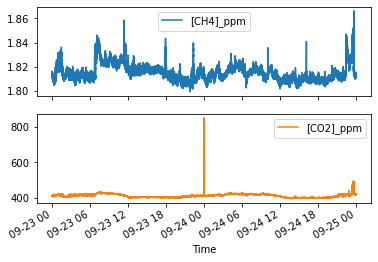

In [4]:
df[['[CH4]_ppm', '[CO2]_ppm']].plot(subplots=True);

### Dask
https://docs.dask.org/en/latest/generated/dask.dataframe.read_csv.html <br><br>
In this case files have been previously modified:
* initial line removed
* initial space removed
* PGP MESSAGE removed

In [5]:
%%time

path = 'Data_dask/ABB-de7/*/'

filenames = [filename for filename in glob.iglob(path + '*_f*.txt')]

usecols = ['SysTime', 'Time', '[CH4]_ppm', '[CO2]_ppm', '[H2O]_ppm', '[CH4]d_ppm',
           '[CO2]d_ppm', 'GasP_torr', 'AmbT_C']

dtype = {'SysTime':'str', 'Time':'str','[CH4]_ppm':'float32','[CH4]d_ppm':'float32',
         '[CO2]_ppm':'float32','[CO2]d_ppm':'float32',
         '[H2O]_ppm':'float32','GasP_torr':'float32','AmbT_C':'float32'} 

df = dd.read_csv(filenames,
                 sep=',',
                 usecols=usecols,
                 dtype=dtype,
                 engine='c'
                 )

df = df.compute()

df = df.set_index('Time')
df.index = pd.to_datetime(df.index, format="%m/%d/%Y%H:%M:%S.%f")

df = df.drop(['SysTime'], axis=1)

df

CPU times: user 1.71 s, sys: 144 ms, total: 1.86 s
Wall time: 1.29 s


,[CH4]_ppm,[CO2]_ppm,[H2O]_ppm,[CH4]d_ppm,[CO2]d_ppm,GasP_torr,AmbT_C
Time,,,,,,,
2021-09-24 02:02:35.908,1.82033,416.312988,17495.500000,1.85274,423.726013,500.592010,27.413500
2021-09-24 02:02:35.991,1.81827,416.526001,17568.500000,1.85078,423.975006,500.597992,27.413601
2021-09-24 02:02:36.126,1.81925,417.212006,17485.199219,1.85163,424.635986,500.677002,27.414801
2021-09-24 02:02:37.103,1.81996,416.873993,17475.500000,1.85233,424.287994,500.618988,27.415800
2021-09-24 02:02:38.098,1.81813,416.019012,17453.000000,1.85043,423.408997,500.673004,27.416700
...,...,...,...,...,...,...,...
2021-09-23 19:02:15.318,1.80894,402.673004,16497.400391,1.83929,409.428009,500.450989,30.764400
2021-09-23 19:02:16.313,1.80820,402.325012,16582.500000,1.83869,409.109009,500.441010,30.767200
2021-09-23 19:02:17.307,1.80747,402.054993,16488.599609,1.83777,408.795990,500.462006,30.775200


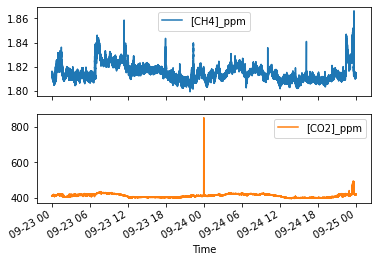

In [6]:
df[['[CH4]_ppm', '[CO2]_ppm']].plot(subplots=True);